# Pi Day - Pi / Not Pi 

![](./images/pienpi.png)

## What it is

* A CNN (ResNet) based image classification built on SageMaker
* Optimized & complied with SageMaker Neo 
* Running inference on the edge - Raspberry Pi

## Data pre processing 

### Generate synthetic data 

Before we can train, we need to generate some additional data - synthetic data that can be used to train the classifier

**Libraries**

Load python libraries

In [2]:
from PIL import Image, ImageEnhance
from skimage.transform import resize
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import uuid
import random
import os

**Display Functions**

Function to display / plot images as needed

In [3]:
def plotImages(pathList, number):
    pp = list(pathList)
    plt.figure(figsize=(15,15))
    for i in range(number):
        plt.subplot(5,5,i+1)
        im = Image.open( pp[i] )
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
    plt.show()

**Import data from S3 to local instance**

Get raw data from S3 to your local instance for pre processing

In [ ]:
!aws s3 cp --recursive s3://{inputbucketname} ./images/ > /dev/null

**Raw image data**

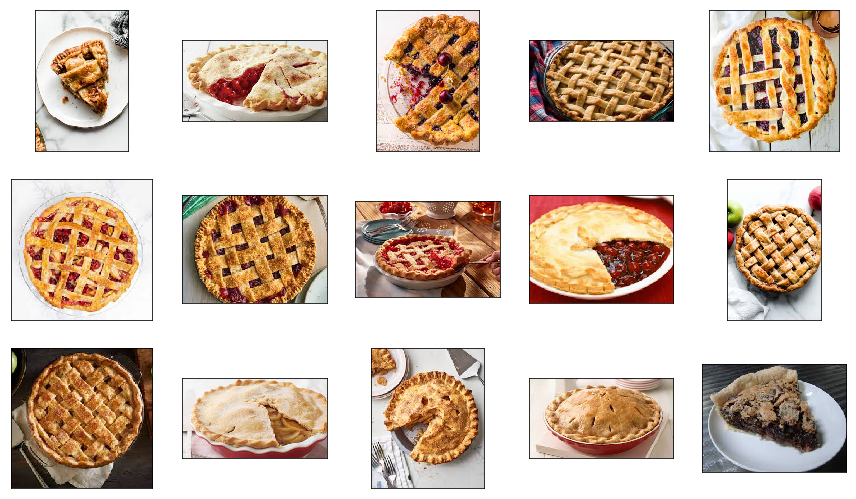

In [6]:
dp = Path('./images/' + 'pie' + '/').glob('*.jpeg')
plotImages(dp, 15)

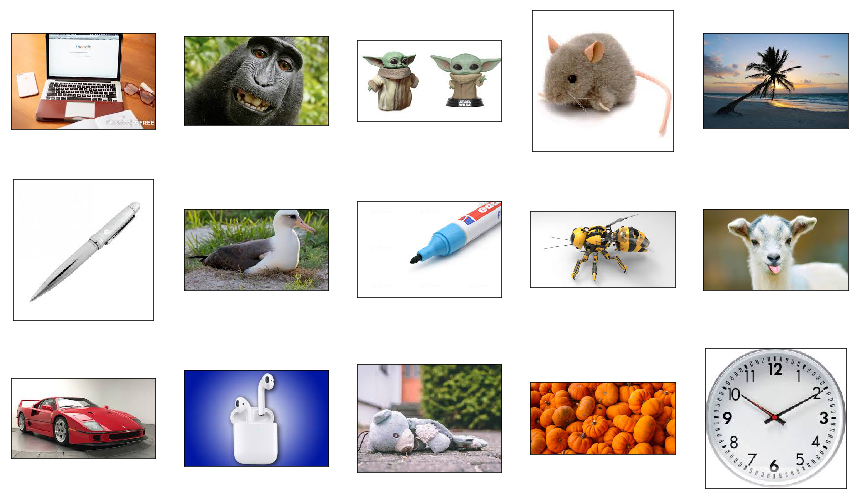

In [7]:
dp = Path('./images/' + 'notpie' + '/').glob('*.jpeg')
plotImages(dp, 15)

**Define base directories**

Define base directories in your local instance

In [ ]:
inputBasePath = './images/'
outputBasePath = './output/'
resizeBasePath = './resize/'
folders = ['pie', 'notpie']

**Resize images**

Resize images to the same size so they can be fed to a fixed input layer. Also add randomness to the file names

In [ ]:
newsize = (244, 244)
for f in folders:
    plist = Path(inputBasePath + f + '/').glob('*.jpeg')

    resizepath = resizeBasePath + f + '/' 
    if not os.path.exists(resizepath):
        os.makedirs(resizepath)
    for path in plist:
        i = Image.open( path )
        i = i.resize(newsize)
        save(i, resizepath + str(uuid.uuid4()) + '.png')

In [ ]:
# Check image sizes
im = Image.open('./resize/notpie/0efdfa1d-3ce1-4306-b2c2-65644ac70173.png')
Image(file_name)
print(im.size)


**Generate sythetic data**

Define transformations and generate synthetic data

In [ ]:
rotations = [0,90,180,270]
randContrastMin, randContrastMax = (0.8, 1.2)
randSharpenMin, randSharpenMax  = (0.8, 1.2)
randColorMin, randColorMax    = (0.8, 1.2)
multiplier = 3

for f in folders:
    plist = Path(resizeBasePath + f + '/').glob('*.png')

    outpath = outputBasePath + f + '/' 
    if not os.path.exists(outpath):
        os.makedirs(outpath)
    
    for path in plist:
        i = Image.open( path )

        for r in rotations:
            
            for m in range(multiplier):
                
                randContrast = random.uniform(randContrastMin, randContrastMax)
                randSharpen = random.uniform(randSharpenMin, randSharpenMax)
                randColor = random.uniform(randColorMin, randColorMax)
                
                i = rotate(i, r)
                i = contrast(i, randContrast)
                i = sharpen(i, randSharpen)
                i = color(i, randColor)
                
                save(i, outpath + str(uuid.uuid4()) + '.png') 
                print('.', end='')
                

**Data Prep**

Shuffle the images and split for training and validation

In [ ]:
allImages = []
for f in folders:
    for p in Path(outputBasePath + f + '/').glob('*.png'):
        allImages.append(str(p))

In [ ]:
random.shuffle(allImages)

In [ ]:
valLen = int(len(allImages)/4)
trainLen = len(allImages) - valLen
trainImg = allImages[:trainLen]
valImg  = allImages[1-valLen-1:]
print(trainLen, valLen)
plotImages(allImages, 25)

**Create LST files**

Create LST files - labels

In [ ]:
f = open("./output/train_lst.lst", "w+")
x = 0
for i in trainImg:
    x = x + 1
    if 'notpie' in i:
        f.write("%i\t0\t%s\n" % (x, i[7:]))
    else:
        f.write("%i\t1\t%s\n" % (x, i[7:]))
f.close()

In [ ]:
f = open("./output/validation_lst.lst", "w+")
x = 0
for i in valImg:
    x = x + 1
    if 'notpie' in i:
        f.write("%i\t0\t%s\n" % (x, i[7:]))
    else:
        f.write("%i\t1\t%s\n" % (x, i[7:]))
f.close()

**Write data back to S3**

In [ ]:
!aws s3 cp --recursive ./output/ s3://{outputbucketname}/ > /dev/null

## Image Classification Model

**Import Packages and Setup**

Start by setting your default S3 bucket. Next we import the SageMaker package and get the execution role. Also create a SageMaker session.
Since we are using the SageMaker builtin image classification algorithm, specify the training image as `image-classification` 

In [ ]:
bucket= 'sampal-pi5'
#prefix = 'output'
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

Specify the channels for training & validation data & LST files

In [ ]:
s3train = 's3://{}/'.format(bucket,prefix)
s3validation = 's3://{}/'.format(bucket,prefix)
s3train_lst = 's3://{}/train_lst.lst'.format(bucket,prefix)
s3validation_lst = 's3://{}/validation_lst.lst'.format(bucket,prefix)

In [ ]:
print (s3train)
print (s3validation)
print(s3train_lst)
print(s3validation_lst)

**Model Build**

Create the Estimator object to define the model and set hyperparameters

In [ ]:
s3_output_location = 's3://{}/output'.format(bucket, prefix)
ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [ ]:
ic.set_hyperparameters(num_layers=152,
                             use_pretrained_model=0,
                             image_shape = "3,224,224",
                             num_classes=2,
                             mini_batch_size=32,
                             epochs=30,
                             learning_rate=0.01,
                             num_training_samples=963,
                             precision_dtype='float32')

**Define Data Channels**

Pass the channels to be used for training. Also specify distribution type here.

In [ ]:
train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_lst': train_data_lst, 'validation_lst': validation_data_lst}

**Training**

Start the training job

In [ ]:
ic.fit(inputs=data_channels, logs=True)

**SageMaker Neo**

Compile and optimize the model using Neo API. In this case specfically for the Raspberry Pi

In [ ]:
optimized_ic = ic.compile_model(target_instance_family='rasp3b', 
                                input_shape={'data':[1, 3, 224, 224]},  # Batch size 1, 3 channels, 224x224 Images.
                                output_path=s3_output_location,
                                framework='mxnet', framework_version='1.2.1')

**Deploy**

Deploy the optimized model for testing using an endpoint

In [ ]:
optimized_ic.image = get_image_uri(sess.boto_region_name, 'image-classification-neo', repo_version="latest")
optimized_ic.name = 'deployed-image-classification'

In [ ]:
optimized_ic_classifier = optimized_ic.deploy(initial_instance_count = 1,
                                              instance_type = 'ml.c5.4xlarge')

**Test Inference**

Test inference via the endpoint

In [ ]:
file_name = './pie.png'
# test image
from IPython.display import Image
Image(file_name)

In [ ]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
optimized_ic_classifier.content_type = 'application/x-image'

In [ ]:
result = json.loads(optimized_ic_classifier.predict(payload))

In [ ]:
result

**Cleanup**

Delete the endpoint to avoid recurring charges

In [ ]:
optimized_ic_classifier.delete_endpoint()